In [1]:
import os, random, h5py, json
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

from vqvae import FlatVQVAE


/home/abghamtm/miniconda3/envs/vqvae-transformer/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1,1,1)
    img = img_tensor * std + mean
    img = img.clamp(0.0, 1.0)
    return (img * 255).byte().permute(1,2,0).cpu().numpy()

def load_vqvae(ckpt_path, device):
    model = FlatVQVAE().to(device)
    sd = torch.load(ckpt_path, map_location=device)
    try:
        model.load_state_dict(sd, strict=False)
    except:
        new = {}
        for k,v in sd.items():
            nk = k.replace('module.', '') if k.startswith('module.') else 'module.' + k
            new[nk] = v
        model.load_state_dict(new, strict=False)
    model.eval()
    return model


In [9]:
# Download once per session; after that you can cache it locally if you want
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes = urllib.request.urlopen(url).read().decode("utf-8").splitlines()

# Quick sanity check
print(len(imagenet_classes))   # should be 1000
print(imagenet_classes[0])     # e.g. 'tench, Tinca tinca'
print(imagenet_classes[281])   # 'tabby, tabby cat' in standard indexing

def label_to_name(label: int) -> str:
    return imagenet_classes[label]


1000
tench
tabby


In [7]:
h5_path = "/home/abghamtm/work/mask_image_reconstruct_image/reconstruction/latent_space/indices_h5/train_rank0.h5"
ckpt_path = "/home/abghamtm/work/mask_image_reconstruct_image/models_checkpoint/vqvae/model_epoch_28_vqvae.pth"
imagenet_root = "/local/reyhasjb/datasets/Imagenet1k/train"   # or val

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_vqvae(ckpt_path, device)

f = h5py.File(h5_path, "r")
indices_ds = f["indices"]
labels_ds = f["labels"]

total = indices_ds.shape[0]
print("Total samples:", total)


Total samples: 1280133


In [8]:
# pick 10 unique labels
unique_labels = list(set(labels_ds[:]))
random.shuffle(unique_labels)
chosen_labels = unique_labels[:10]

# find one index per label
chosen_indices = []
for lbl in chosen_labels:
    idx = np.where(labels_ds[:] == lbl)[0][0]
    chosen_indices.append(idx)

chosen_indices


[180, 4448, 436, 55, 924, 2554, 736, 549, 1417, 1543]

In [10]:
list(zip(chosen_indices, chosen_labels))

[(180, 979),
 (4448, 934),
 (436, 530),
 (55, 336),
 (924, 705),
 (2554, 730),
 (736, 900),
 (549, 956),
 (1417, 866),
 (1543, 136)]

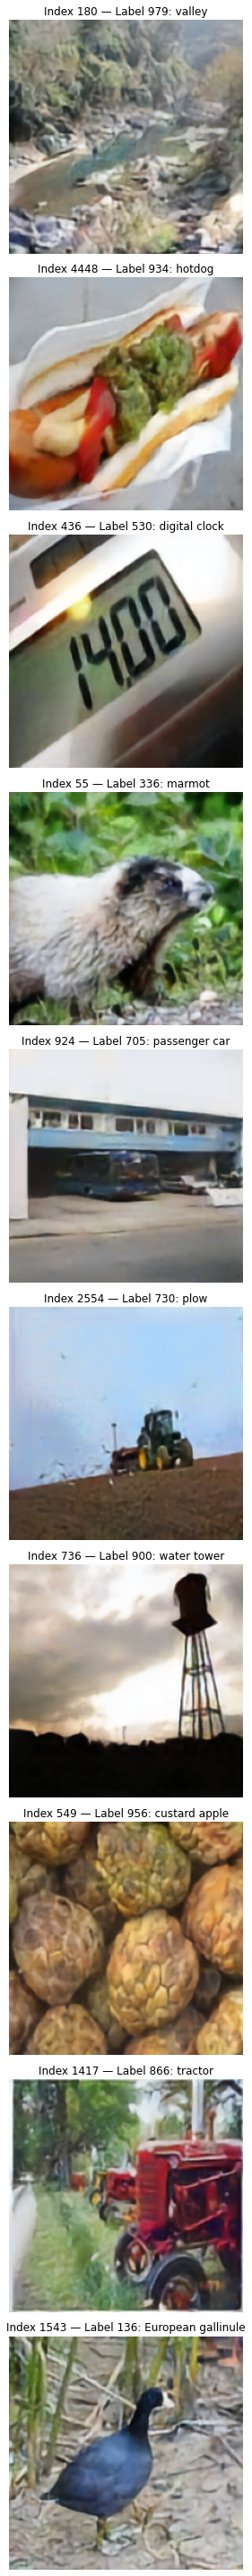

In [11]:
plt.figure(figsize=(8, 4 * len(chosen_indices)))

for i, idx in enumerate(chosen_indices):
    ids   = indices_ds[idx]      # shape: (H, W) or (T,)
    label = int(labels_ds[idx])
    name  = label_to_name(label)

    ids_t = torch.from_numpy(ids).unsqueeze(0).long().to(device)  # (1, H, W) or (1, T)
    with torch.no_grad():
        # Adjust if your decode function has a different name/signature
        recon = model.decode_code(ids_t)  # -> (1, C, H, W)

    recon = recon.squeeze(0).cpu()  # (C, H, W)
    recon_img = unnormalize(recon)  # -> uint8 (H, W, C)

    plt.subplot(len(chosen_indices), 1, i + 1)
    plt.imshow(recon_img)
    plt.title(f"Index {idx} — Label {label}: {name}")
    plt.axis("off")

plt.tight_layout()
plt.show()
